<a href="https://colab.research.google.com/github/wilbs43/geometric-algos/blob/master/tspb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traveling Salesman Problem with Blockades

Wilbur Li

May 2020 for 6.850, Geometric Algorithms

MIT Class of 2020

In [0]:
from sympy import Point, Polygon, pi, symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import random, numpy as np
from shapely.geometry import LineString
import time 

# A Star

In [0]:
## A* implementation from 
# adapted from https://www.redblobgames.com/pathfinding/a-star/implementation.html

class EdgeGraph:
  def __init__(self):
    self.E = {}
    self.V = {}
  def neighbors(self, id):
    return self.E[id]
  def cost(self,a,b):
    # print(11,self.V)
    (x1, y1) = self.V[a] 
    (x2, y2) = self.V[b]
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
  def heuristic(self,a, b):
    (x1, y1) = self.V[a] 
    (x2, y2) = self.V[b]
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

import heapq
class PriorityQueue:
    def __init__(self):
        self.elements = []
    def empty(self):
        return len(self.elements) == 0
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    def get(self):
        return heapq.heappop(self.elements)[1]

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        if current == goal:
            break
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + graph.heuristic(goal, next)
                frontier.put(next, priority)
                came_from[next] = current
    return came_from, cost_so_far

def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path



# Blockaded Euclidean distance


True
blockade_sample {0: [(2.16825572165507, 0.7172464442297157), (2.4423080758459434, 1.9933474760092549)], 1: [(0.11681784970852171, 1.5931309879727589), (0.3015098078129732, 2.1314161164733)]} 
BBG {2: [3, 4, 5], 3: [2, 4, 5], 4: [2, 3, 5], 5: [2, 3, 4]}
create graph ({0: [1, 2, 3, 4, 5], 1: [0, 2, 3, 4, 5], 2: [3, 4, 5, 0, 1], 3: [2, 4, 5, 0, 1], 4: [2, 3, 5, 0, 1], 5: [2, 3, 4, 0, 1]}, {0: (0, 0), 1: (6, 6), 2: (2.16825572165507, 0.7172464442297157), 3: (2.4423080758459434, 1.9933474760092549), 4: (0.11681784970852171, 1.5931309879727589), 5: (0.3015098078129732, 2.1314161164733)})
[0, 1] 6.020797289396148


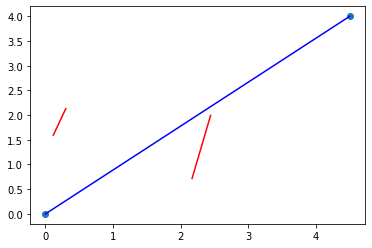

In [332]:
## Find Euclidean distance given segment blockades

def create_blockade_base_graph(blockades):
  '''
  blockades : dict, blockades as line segments
  ret base_map : all valid edges between blockade endpoints that
  '''
  b_endpts = dict()
  i = 2
  for id,blockade in blockades.items():
    b_endpts[i] = blockade[0]
    b_endpts[i+1] = blockade[1]
    i += 2
  
  base_map = {id:[] for id in b_endpts.keys()}
  for id in b_endpts.keys():
    for jd in b_endpts.keys():
      if id >= jd: continue
      edge_candidate = [b_endpts[id],b_endpts[jd]]
      if not check_intersect(edge_candidate, blockades):
        # print(31,'edge approved',edge_candidate)
        base_map[id] += [jd]
        base_map[jd] += [id]
  return base_map

def check_intersect(edge, segments):
  '''
  edge : tuple, (begin, end)
  segments : dict, with number:(begin,end)
  ret : bool, whether edge crosses any segment from segments
  '''
  edge_ls = LineString(edge)
  clear = False;
  for id,pair in segments.items():
    seg_ls = LineString(pair)
    clear |= edge_ls.crosses(seg_ls)
  return clear

def create_graph(start, end, segments,blockade_base_graph):
  '''
  start : start pt
  end : stop pt
  segments : segments not to be crossed
  ret g : all valid edges created from the start, stop, and segments endpoints
  ret v : all vertices and their coordinates
  '''
  # all_points = {0:start, 1:end}
  all_points = dict()
  all_points[0] = start
  all_points[1] = end
  i = 2
  for id,segment in segments.items():
    all_points[i] = segment[0]
    all_points[i+1] = segment[1]
    i+=2
  graph = {0:[],1:[]}

  for id,val in blockade_base_graph.items():
    graph[id] = val.copy()
  
  for id in [0,1]:
    for jd in all_points.keys():
      if id >= jd: continue
      edge_candidate = [all_points[id],all_points[jd]]
      if not check_intersect(edge_candidate, segments):
        graph[id] += [jd]
        graph[jd] += [id]
  return graph, all_points

def find_path(start,end,segments,blockade_base_graph):
  ''' Use A* on graph to find shortest path
  segments : dict, blocking segments, e.g. {0:[(3,5),(4,3)],1:[(4,6),(6,0)],2:[(1,4),(3,2)],3:[(1,6),(2,4.5)]}
  start: tuple, start point e.g. (0,0)
  end: tuple, e.g. (6,6)
  '''
  e,v = create_graph(start,end,segments,blockade_base_graph)
  eg = EdgeGraph()
  eg.E = e
  eg.V = v
  came_from, cost_so_far = a_star_search(eg,0,1)
  path = reconstruct_path(came_from,0,1)
  return path, cost_so_far, v, e

## test code
print(check_intersect([(1,2),(4,6)],{1:[(1,4),(5,1)]}))  # True

blockade_sample = {0: [(2.16825572165507, 0.7172464442297157), (2.4423080758459434, 1.9933474760092549)], 1: [(0.11681784970852171, 1.5931309879727589), (0.3015098078129732, 2.1314161164733)]}
bg = create_blockade_base_graph(blockade_sample)
print('blockade_sample',blockade_sample,'\nBBG', bg)
print('create graph',create_graph((0,0),(6,6),blockade_sample,bg))

start = (0,0)
end = (4.5,4)
path, total_dist,v,e = find_path(start,end,blockade_sample,bg)
print(path,total_dist[1])


## plot
# path
for i in range(len(path)-1):
  plt.plot([v[path[i]][0],v[path[i+1]][0]],[v[path[i]][1],v[path[i+1]][1]],color='blue')
# blockades
for id,pair in blockade_sample.items():
  plt.plot([pair[0][0],pair[1][0]],[pair[0][1],pair[1][1]],color='red')
plt.scatter([start[0],end[0]],[start[1],end[1]])

# Christophides Algorithm

In [0]:
## Christofides Algorithm
# will approximate ideal answer within 50%
# adapted from https://github.com/Retsediv/ChristofidesAlgorithm

def tsp(data,usingBlockades=True):
    # build a graph
    G = build_graph(data,usingBlockades)
    print("Graph: ", G)

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[0] = True

    length = 0

    for v in eulerian_tour[1:]:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    path.append(path[0])

    print("Result path: ", path)
    print("Result length of the path: ", length)

    return length, path


def get_length(x1, y1, x2, y2,usingBlockades=True):
    if not usingBlockades:
      return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1.0 / 2.0)
    dist,path = DIST_LOOKUP[hash_pts((x1,y1),(x2,y2))]
    return dist
    

def build_graph(data,usingBlockades):
    graph = {}
    for this in range(len(data)):
        for another_point in range(len(data)):
            if this != another_point:
                if this not in graph:
                    graph[this] = {}

                graph[this][another_point] = get_length(data[this][0], data[this][1], data[another_point][0],
                                                        data[another_point][1],usingBlockades)

    return graph


class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)

    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):

    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

# Main: TSP with Blockades

Features
*   Generates random set of checkpoints and random set of blockades
*   Runs TSPB (Christofides TSP with Blockades) on this set of checkpoints.

In the plot
*   Light blue lines indicate the sequence of travel through the TSP tour
*   Orange lines indicate route that is actually traveled to travel around every blockade



Known issues
*   Christofides TSP solution sometimes yields paths that visit the same vertex twice. Further, the first point in the point list, (0,0) is not included in the tour. 
*   Sometimes randomly generated blockades will fence off a region completely. If a checkpoint is assigned in the interior of this inaccessible region, the distance-finding A* algorithm will fail



In [0]:
## create field of points 
base_loc = [0,0]      # location of the rover base
map_side = 6        # length of farthest dist from rover in either direction

# create checkpoints
num_checkpoints = 20  # num checkpoints
point_list = [(0,0)]
point_list += [[random.uniform(0,map_side),random.uniform(0,map_side)] for i in range(num_checkpoints)]

# create blockades
num_blockades = 10  # num blockades
blockades4 = {0:[(3,5),(4,3)],1:[(4,6),(6,0)],2:[(1,4),(3,2)],3:[(1,6),(2,4.5)]}
blockades = dict()
for i in range(num_blockades):
  blockades[i]=[(random.uniform(0,map_side),random.uniform(0,map_side)),(random.uniform(0,map_side),random.uniform(0,map_side))]
BLOCKADES = blockades  # all blockades

# prepare hashing for distance lookup
HASH_BASE = 13
def hash_pts(point1,point2):
  ''' Hashing protocol for distance lookup table
  '''
  return round(HASH_BASE*point1[0] - point1[1] + 2*HASH_BASE*point2[0] + 2*point2[1],3)

In [335]:
## compute TSPB tours
# precompute distances between checkpoints
time_start = time.clock()
DIST_LOOKUP = {}
BBG = create_blockade_base_graph(BLOCKADES)
BLOCKADES_V = {}  # to track all blockade endpoints. vals useless for keys 0,1
for i in range(len(point_list)):
  for j in range(i+1,len(point_list)):
    if i == j: continue
    global DIST_LOOKUP,V
    point1 = point_list[i]
    point2 = point_list[j]
    path, total_dist, v, e = find_path(point1,point2,BLOCKADES,BBG)
    DIST_LOOKUP[hash_pts(point1,point2)] = (total_dist[1],path)
    rp = path.copy()
    rp.reverse()
    rp[0] = 0
    rp[-1] = 1
    DIST_LOOKUP[hash_pts(point2,point1)] = (total_dist[1],rp)
    BLOCKADES_V = v

# call TSPB
length, path = tsp(point_list,usingBlockades=True)

time_elapsed = (time.clock() - time_start)
print('Time taken',time_elapsed)

Graph:  {0: {1: 3.1114036973689827, 2: 8.354657171826615, 3: 4.846082177661254, 4: 9.452172126248557, 5: 0.3026190996676207, 6: 9.407413706005304, 7: 4.648160824693784, 8: 4.088142513092093, 9: 8.304888284090922, 10: 6.730608034844094, 11: 2.4071282801596774, 12: 7.220313844933599, 13: 9.415849492350137, 14: 5.896167401992971, 15: 8.351182177743325, 16: 5.39785588998653, 17: 4.438576083296614, 18: 0.22355369206733894, 19: 4.7529687578582225, 20: 0.5532414369587756}, 1: {0: 3.1114036973689827, 2: 5.569658723499624, 3: 2.246959304119173, 4: 7.646234912578464, 5: 2.817049063829021, 6: 6.622415257678311, 7: 1.7931483310738705, 8: 1.2331300194721782, 9: 7.357269424180944, 10: 3.9456095865171013, 11: 0.7052641236609479, 12: 4.435315396606606, 13: 6.630851044023146, 14: 8.235280351494788, 15: 8.03617160749918, 16: 2.612857441659538, 17: 6.773268225446028, 18: 2.9301228498209997, 19: 1.9037281099494692, 20: 2.847713242699641}, 2: {0: 8.354657171826615, 1: 5.569658723499624, 3: 3.78649804019027

[13, 6, 12, 10, 16, 3, 19, 7, 8, 1, 11, 5, 18, 20, 17, 14, 9, 15, 2, 4, 13, 13] 22


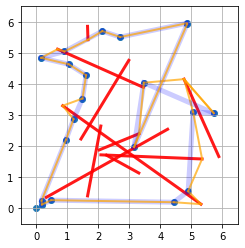

In [336]:
## plot tours on map
print(path,len(path))

# points
fig, ax = plt.subplots()
plt.scatter([point_list[i][0] for i in range(len(point_list))],
         [point_list[i][1] for i in range(len(point_list))],marker='o')
ax.set_aspect(1)
plt.xlim(-.5,map_side+.5)
plt.ylim(-.5,map_side+.5)

# blockades
for id,pair in BLOCKADES.items():
  plt.plot([pair[0][0],pair[1][0]],[pair[0][1],pair[1][1]],color='red',alpha=0.9,linewidth=3)
  pass

# tours
for i in range(len(path)-1):
  start = point_list[path[i]]
  end = point_list[path[i+1]]
  if start == end: continue
  plt.plot([start[0],end[0]],[start[1],end[1]],color='blue', linewidth=5, alpha=0.2) # direct line
  dist,mid_path = DIST_LOOKUP[hash_pts(start,end)]
  # print('found',hash_pts(start,end),'mid_path',mid_path)
  adjusted_V = BLOCKADES_V
  adjusted_V[0] = start
  adjusted_V[1] = end
  for i in range(len(mid_path)-1):
    plt.plot([adjusted_V[mid_path[i]][0],adjusted_V[mid_path[i+1]][0]],
             [adjusted_V[mid_path[i]][1],adjusted_V[mid_path[i+1]][1]],color='orange',alpha=.7, linewidth=2)
plt.grid()
plt.show()

[0, 17, 1] 6.9427386818914725


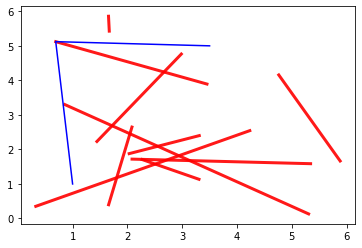

In [337]:
## debug
# blockades
path, total_dist,v,e = find_path((3.5,5),(1,1),BLOCKADES,BBG)
print(path,total_dist[1])

## plot
for id,pair in BLOCKADES.items():
  plt.plot([pair[0][0],pair[1][0]],[pair[0][1],pair[1][1]],color='red',alpha=0.9,linewidth=3)
  pass
for i in range(len(path)-1):
  plt.plot([v[path[i]][0],v[path[i+1]][0]],[v[path[i]][1],v[path[i+1]][1]],color='blue')